## Deep Learning

## Project: Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [40]:
# Import stuff
import pickle
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdmn
from tqdm import tqdm
import tensorflow as tf
import cv2
from scipy.misc import imresize

In [2]:
# TODO: Fill this in based on where you saved the training and testing data

training_file = './traffic-signs-data/train.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

X_valid = X_test[:5052]
y_valid = y_test[:5052]

X_test = X_test[5052:]
y_test = y_test[5052:]

print("Successfully imported data")

Successfully imported data


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `features` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `labels` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `sizes` is a list containing tuples, (width, height) representing the the original width and height the image.
- `coords` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [3]:
# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = np.shape(X_train[0])

# How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 7578
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s).

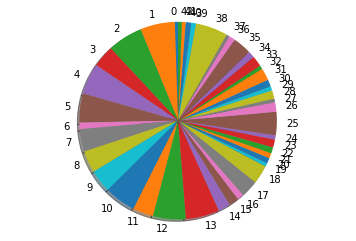

In [4]:
### Data exploration visualization goes here.

# Visualizations will be shown in the notebook.
%matplotlib inline

sizes = [0] * 43

for label in train['labels']:
    sizes[label] += 1
    
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42'

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, labeldistance = 1.1,
        shadow=True, startangle=90)

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

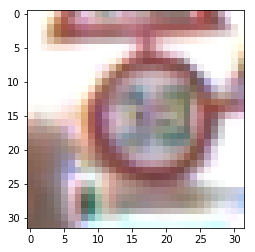

In [5]:
# Plot a random image from the dataset
plt.imshow(X_train[random.randrange(0, len(X_train), 1)])

plt.show()


## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs.

### Implementation

In [6]:
### Preprocess the data here.

def reg(x):

    pbar = tqdmn(total = len(x))
    x_ = np.array([(x[0] - np.mean(x[0])) / np.std(x[0])])

    for image in x[1:]:
        x_ = np.append(x_, [(image - np.mean(image)) / np.std(image)], 0)
        pbar.update(1)

    return x_

In [ ]:
X_train = reg(X_train)
tqdm.write("Training data processed")

X_test = reg(X_test)
tqdm.write("Testing data processed")

X_valid = reg(X_valid)
tqdm.write("Validation data processed")

np.save('./regdata/train.npy', X_train)
np.save('./regdata/test.npy', X_test)
np.save('./regdata/valid.npy', X_valid)

In [7]:
# Now onwards we only need to load the regularised data

X_train = np.load('./regdata/train.npy')
X_test = np.load('./regdata/test.npy')
X_valid = np.load('./regdata/valid.npy')

print('Regularised data loaded')

Regularised data loaded


I chose to bring the pixel values of the images to 0 mean and unit variance. The transformations were performed per image.

I did this to regularise the features to enable faster convergence to minimum error.

In [8]:
'''Generate additional data (via an augmentation pipline) that
adds random brightness and contrast to the images'''

def augment(x):

    x = tf.image.random_brightness(x, max_delta=0.2)
    x = tf.image.random_contrast(x, 0.5, 2)

    return x

I took a slice off from the testing data and used it as the validation data. I did this because the testing data was an assorted collection of images of traffic signs from various classes all mixed together. Hence, taking a slice off of it gave a decent validation set pretty easily.

I created an image augmentation pipeline to generate additional data. The pipeline takes images from the training set and randomly changes their brightness and contrast by a small factor.

I did this to make my model generalise well, for it sees no 2 identical images twice. Also, the slight brightness and contrast variations simulate actual variations which can result from variations in ambient light conditions at the time of collection of data.

I specifically did NOT use cropping, rotation or translation. This is because rotation of an image of an arrow, for example, can have disastrous consequences to the semantics of the image. I did not use cropping or translation because I did not want any region of the image to be lost as a result of this.

In [9]:
### Defined architecture here.
### NOTE: The method name `LeNet` is misleading, it is actually
### a modified version of LeNet

EPOCHS = 50
BATCH_SIZE = 512

#####################################################################################################

from tensorflow.contrib.layers import flatten

def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    # Layer 0: Convolutional. Input = 32x32x3. Output = 32x32x3.
    w0 = tf.Variable(tf.truncated_normal([1, 1, 3, 3], mean = mu, stddev = sigma))
    b0 = tf.Variable(tf.zeros([3]))
    conv0 = tf.nn.conv2d(x, w0, strides = [1, 1, 1, 1], padding = 'VALID')
    conv0 = tf.nn.bias_add(conv0, b0)

    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x9.
    w1 = tf.Variable(tf.truncated_normal([5, 5, 3, 9], mean = mu, stddev = sigma))
    b1 = tf.Variable(tf.zeros([9]))
    conv1 = tf.nn.conv2d(conv0, w1, strides = [1, 1, 1, 1], padding = 'VALID')
    conv1 = tf.nn.bias_add(conv1, b1)

    # Activation.
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, keep_prob = prob)
    
    # Pooling. Input = 28x28x9. Output = 14x14x9.
    pool1 = tf.nn.max_pool(conv1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID')

    # Layer 2: Convolutional. Output = 10x10x27.
    w2 = tf.Variable(tf.truncated_normal([5, 5, 9, 27], mean = mu, stddev = sigma))
    b2 = tf.Variable(tf.zeros([27]))
    conv2 = tf.nn.conv2d(pool1, w2, strides = [1, 1, 1, 1], padding = 'VALID')
    conv2 = tf.nn.bias_add(conv2, b2)

    # Activation.
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(conv2, keep_prob = prob)

    # Pooling. Input = 10x10x27. Output = 5x5x27.
    pool2 = tf.nn.max_pool(conv2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID')
    
    # Flatten. Input = 5x5x27. Output = 675.
    flat = flatten(pool2)

    # Layer 3: Fully Connected. Input = 675. Output = 120.
    w3 = tf.Variable(tf.truncated_normal([675, 120], mean = mu, stddev = sigma))
    b3 = tf.Variable(tf.zeros([120]))
    full1 = tf.matmul(flat, w3)
    full1 = tf.nn.bias_add(full1, b3)

    # Activation.
    full1 = tf.nn.relu(full1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    w4 = tf.Variable(tf.truncated_normal([120, 84], mean = mu, stddev = sigma))
    b4 = tf.Variable(tf.zeros([84]))
    full2 = tf.matmul(full1, w4)
    full2 = tf.nn.bias_add(full2, b4)

    # Activation.
    full2 = tf.nn.relu(full2)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    w5 = tf.Variable(tf.truncated_normal([84, n_classes], mean = mu, stddev = sigma))
    b5 = tf.Variable(tf.zeros([n_classes]))
    logits = tf.matmul(full2, w5)
    logits = tf.nn.bias_add(logits, b5)

    return logits

My model is essentially a modified LeNet architecture.

I started off with a convolution of depth 3 after reading [this paper](https://arxiv.org/pdf/1606.02228.pdf) which mentions that enabling the model to learn its own colour space is one of the best colour spaces.

This is followed by another convolution of depth 9 to capture primitive features. I used dropout at this layer. This is followed by max pooling.

I then repeat this process of convolution-dropout-pooling. I triple the depth in the convolution. This is to enable the model to learn more complex features.

Then I flatten the outputs and send them to 3 fully connected layers.

A TensorBoard visualisation is attached here.

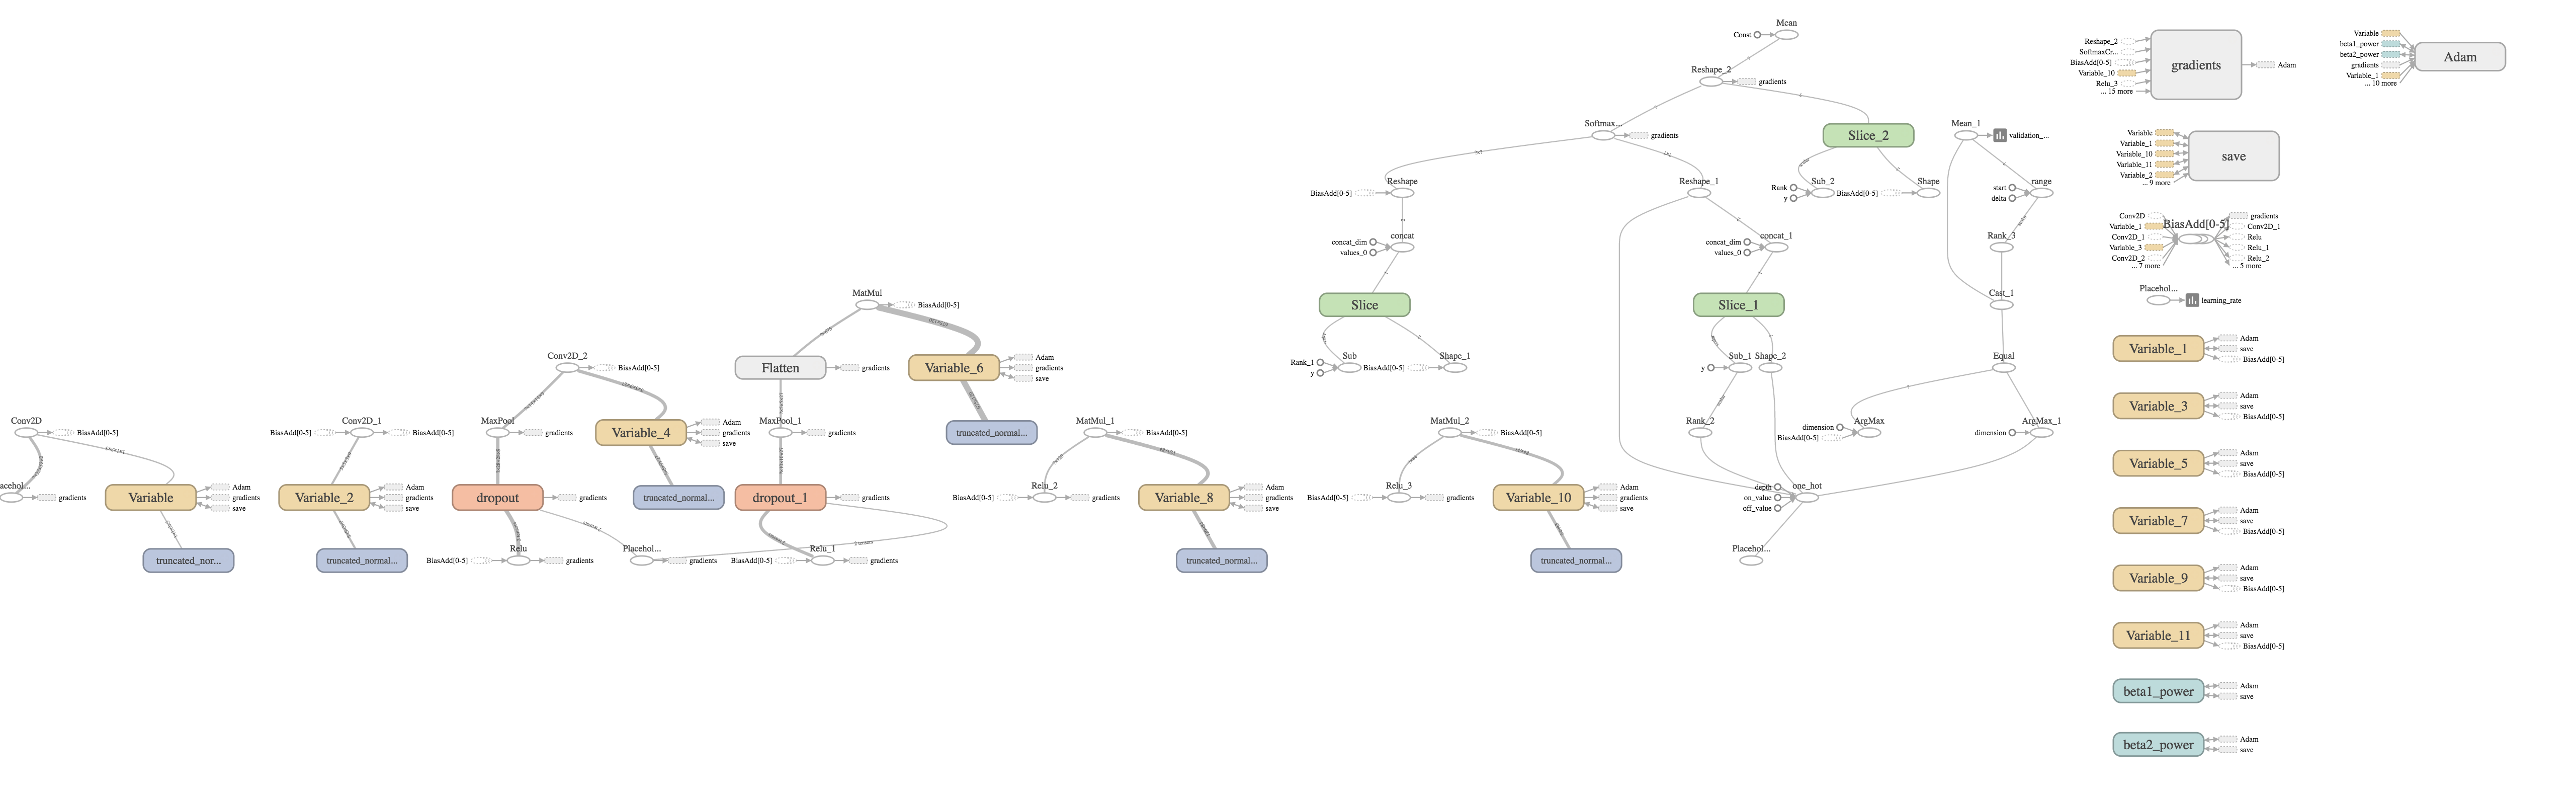

In [14]:
from IPython.display import Image
Image("graph.png")

In [43]:
### Train your model here.

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
prob = tf.placeholder(tf.float32, (None))
one_hot_y = tf.one_hot(y, n_classes)

rate = tf.placeholder(tf.float32, (None))
rate_summary = tf.summary.scalar('learning_rate', rate)
alpha = 0.00005
initial_alpha = 0.00005

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = alpha)
training_operation = optimizer.minimize(loss_operation)

model_prediction = tf.argmax(logits, 1)
actual = tf.argmax(one_hot_y, 1)

correct_prediction = tf.equal(model_prediction, actual)
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
accuracy_summary = tf.summary.scalar('validation_accuracy', accuracy_operation)
saver = tf.train.Saver()

summary = tf.summary.merge_all()
writer = tf.summary.FileWriter('./summary', tf.get_default_graph())

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, prob: 1., rate: alpha})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
import sys

with tf.Session() as sess:

    choice = input('\n\nDo you want to: \n\n1. Start training afresh \n\
2. Continue from the last saved training \nEnter your response here: ')

    if choice == '1':

        sess.run(tf.global_variables_initializer())

    elif choice == '2':
        saver.restore(sess, './lenet')

    else:
        sys.exit()
        
    num_examples = len(X_train)

    tqdm.write("Training...")
    tqdm.write('\n')

    pbar = tqdm(total = EPOCHS * (len(X_train) + 1)//BATCH_SIZE)
    total = EPOCHS * (len(X_train) + 1)//BATCH_SIZE
    count = 0
    
    from sklearn.utils import shuffle

    try:

        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)

            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                batch_x = sess.run(augment(batch_x))
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, prob: 0.5, rate: alpha})

                count += 1
                alpha = initial_alpha * (total - count)/total

                pbar.update(1)

            validation_accuracy = evaluate(X_valid, y_valid)
            writer.add_summary(sess.run(summary, feed_dict = {x: X_valid, y: y_valid, prob: 1., rate: alpha}))
            tqdm.write("{}".format(validation_accuracy))
            
    finally:
        choice = input('Save the model (y/n)? ')

        if choice == 'y':
            saver.save(sess, './lenet')
            tqdm.write("Model saved")

        else:
            tqdm.write('Session\'s training discarded')

I used Adam Optimizer. Batch size was 512 (which could comfortably fit in memory). I implemented a linear decay of the learning rate (which https://arxiv.org/abs/1606.02228 said gave the best performance).

---

## Step 3: Test a Model on New Images

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

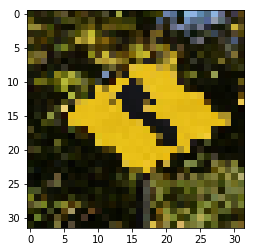

In [11]:
### Load the images and plot them here.

image1 = cv2.imread('./images/image1.jpg')
image1 = np.fliplr(image1.reshape(-1,3)).reshape(image1.shape)
image1 = np.array(image1, dtype=np.uint8)
image1 = imresize(image1, (32, 32, 3))
plt.imshow(image1)
plt.show()

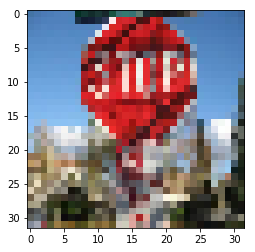

In [12]:
image2 = cv2.imread('./images/image2.jpg')
image2 = np.fliplr(image2.reshape(-1,3)).reshape(image2.shape)
image2 = np.array(image2, dtype=np.uint8)
image2 = imresize(image2, (32, 32, 3))
plt.imshow(image2)
plt.show()

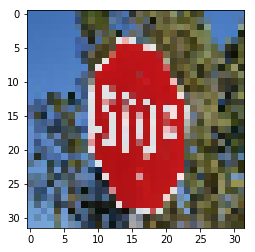

In [13]:
image3 = cv2.imread('./images/image3.jpg')
image3 = np.fliplr(image3.reshape(-1,3)).reshape(image3.shape)
image3 = np.array(image3, dtype=np.uint8)
image3 = imresize(image3, (32, 32, 3))
plt.imshow(image3)
plt.show()

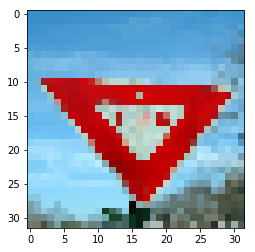

In [14]:
image4 = cv2.imread('./images/image4.jpg')
image4 = np.fliplr(image4.reshape(-1,3)).reshape(image4.shape)
image4 = np.array(image4, dtype=np.uint8)
image4 = imresize(image4, (32, 32, 3))
plt.imshow(image4)
plt.show()

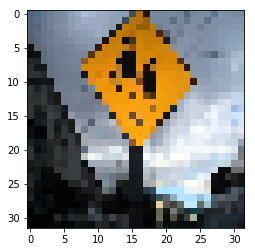

In [15]:
image5 = cv2.imread('./images/image5.jpg')
image5 = np.fliplr(image5.reshape(-1,3)).reshape(image5.shape)
image5 = np.array(image5, dtype=np.uint8)
image5 = imresize(image5, (32, 32, 3))
plt.imshow(image5)
plt.show()

I am running the model on the 5 images plotted above. I think the first image may show interesting behaviour because the background of the picture is similar to the colour of the traffic sign.

I believe the second image will be a bit difficult to recognise because it has varying light conditions (a part of the sign is in shadow).

In [ ]:
### Run the predictions here.

images = [image1, image2, image3, image4, image5]

images = reg(images)
images = np.array(images, dtype=np.float32)

In [2]:
with tf.Session() as sess:

    saver.restore(sess, './lenet')
    print(sess.run(model_prediction, feed_dict={x: images, y: y_valid, prob: 1., rate: alpha}))

[39, 14, 14, 13, 28]


My model recognised images provided by me.

Accuracy = 100% on 5 images!
My test accuracy was 94%, but my model could recognise all the images provided by me.